Let's build an algorithm that can automatically correct a rotated image:

In [1]:
!pip install imutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import paths
import os
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=8a17406296708f1ac662e5a35d6d0240f6e3b446536424654174acb275d30efc
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Since we want to use it in our selfie background removal app, we'll use the same dataset:

In [2]:
clip_img_paths = list(imutils.paths.list_images('../input/aisegmentcom-matting-human-datasets/clip_img'))
print("{} pictures".format(len(clip_img_paths)))


34427 pictures


In [3]:
train_paths, test_paths = train_test_split(clip_img_paths, test_size=0.05)
train_paths, val_paths = train_test_split(train_paths, test_size=0.1)

We'll build a preprocessor that randomly rotates each image, and sets the target to 1 if the image is correcly oriented and 0 otherwise:

In [4]:
def preprocessor(clip_path):
    
    image = load_img(clip_path, target_size=(224,224,3))
    
    random_rotation = np.random.randint(4)
    
    # 1 if the it rotates 0 degrees, 0 otherwise
    target = (random_rotation==0)
    image = np.rot90(image, random_rotation)
    image = img_to_array(image)
    
    # preprocessing function of MobileNetV2
    image = mobilenet_v2.preprocess_input(image)
    
    
    return (image, target)

In [5]:
def training_generator(path_split, batch_size=128):
    while True:
        for i in range(len(path_split) // batch_size):
            try:
                clip_paths = path_split[batch_size*i:batch_size*(i+1)]
                preprocessed_pairs = [preprocessor(clip_path) for clip_path in clip_paths]
                images = [pair[0] for pair in preprocessed_pairs] 
                targets = [pair[1] for pair in preprocessed_pairs] 

                images = np.array(images) 
                targets = np.array(targets) 

                yield(images, targets)
                
            except:
                continue

We'll use transfer learning, and in particular, fine-tuning. Since we need the prediction to be fast, we'll use the MobileNetV2 (with the pretrained Imagenet weights):

In [6]:
orig_mobilenetv2 = MobileNetV2(include_top="True", weights="imagenet")

14540800/14536120 [==============================] - 0s 0us/step


In [7]:
orig_mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [9]:
inputs = orig_mobilenetv2.input
outputs = orig_mobilenetv2.get_layer("global_average_pooling2d").output
headless_mobilenetv2 = Model(inputs=inputs, outputs=outputs)

In [10]:
mobilenetv2 = Sequential([
    headless_mobilenetv2,
    BatchNormalization(),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [11]:
mobilenetv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [12]:
mobilenetv2.get_layer("model").trainable = False
mobilenetv2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [13]:
mobilenetv2.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
train_gen = training_generator(train_paths)
val_gen = training_generator(val_paths)

In [15]:
H = mobilenetv2.fit(train_gen, steps_per_epoch=len(train_paths)//128, validation_data=val_gen,
             validation_steps=len(val_paths)//128, epochs=2)

Epoch 1/2
229/229 [==============================] - 511s 2s/step - loss: 0.1301 - accuracy: 0.9500 - val_loss: 0.0109 - val_accuracy: 0.9972
Epoch 2/2
229/229 [==============================] - 401s 2s/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.0133 - val_accuracy: 0.9959


In [32]:
mobilenetv2.save("mobilenetv2.h5")

In [9]:
mobilenetv2 = load_model("../input/mobilenet/mobilenetv2 (1).h5")

Now, let's build the function that will automatically rotate an image to its correct orientation:

In [10]:
def is_correctly_oriented(image): 
    
    # returns the estimated probability that the given image has correct orientation
    # assumes that the image has shape of (224,224,3)
    image = img_to_array(image)
    
    # preprocessing function of MobileNetV2
    preprocessed_image = mobilenet_v2.preprocess_input(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    correctly_oriented = mobilenetv2.predict(preprocessed_image)[0][0]
    
    return correctly_oriented
    

In [17]:
def correct_orientation(image):
    # returns the correct orientation of the image, assumes that the image has 
    # shape of (224,224,3)
    
    correctly_oriented = is_correctly_oriented(image)
    
    # if it's very likely to be already correctly oriented, return 0
    if correctly_oriented > 0.9:
        return 0
    
    # otherwise, let's compute all the probabilities:
    probabilities = [correctly_oriented]
    for i in range(1,3):
        rotated_image = np.rot90(image, i)
        probabilities.append(is_correctly_oriented(rotated_image))
        
    n_rotations_needed = np.argmax(probabilities)
    
    return np.rot90(image, n_rotations_needed)
        

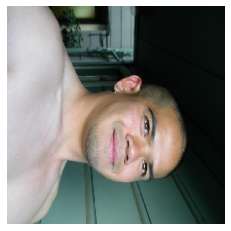

In [21]:
image = load_img(clip_img_paths[0], target_size=(224,224,3))
image = np.rot90(image,3)
plt.imshow(image)
plt.axis(False)
plt.show()

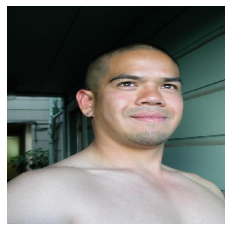

In [22]:
image = correct_orientation(image)
plt.imshow(image)
plt.axis(False)
plt.show()

Success!